<ipython-input-2-a86301cd1e3c>:34: FutureWarning: The default value of regex will change from True to False in a future version.
  data['Leading Comment'] = data['Leading Comment'].str.replace('[^\w\s]','')


<AxesSubplot:>

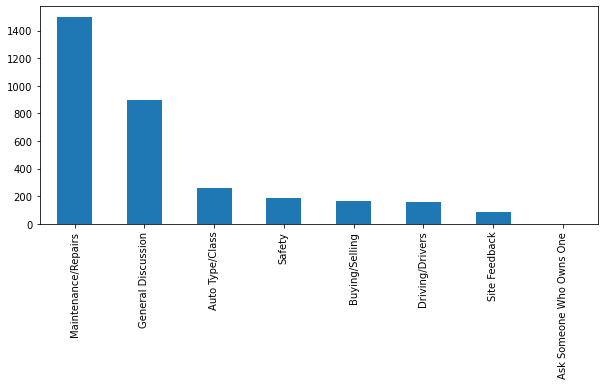

In [2]:
# !pip install gensim
# !pip install sklearn
# %matplotlib inline
#for complete guide refer to https://github.com/mentorchains/level1_post_recommender_20/blob/md2/webScraping_EDA_tutorials/Processing%20Textual%20Data.ipynb 

import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from textblob import TextBlob #for spelling correction
from textblob import Word
from nltk.stem import PorterStemmer #removes suffices i.e. "ing", "ly", "s" etc
stop = stopwords.words('english')
data = pd.read_csv('/Users/jeff/Documents/Cartalk_eda/combined_csv.csv') #change in accordance to whatever path you have for your csv in your filesystem
# print(data.shape) #prints row and column quantity in that order
data = data[[ 'Unnamed: 0', 'Topic Title', 'Category', 'Tags', 'Commenters',
        'Leading Comment', 'Other Comments', 'Likes', 'Views']]

#cleaning data
data.dropna(inplace=True)
data.isnull().sum()
data['Leading Comment'][:5].apply(lambda x: str(TextBlob(x).correct())) #applies textual corrections to the first 5 rows
data['Leading Comment'] = data['Leading Comment'].apply(lambda x: " ".join(x.lower() for x in x.split())) #applies lowercase to all words
data['Leading Comment'] = data['Leading Comment'].str.replace('[^\w\s]','')
data['Leading Comment'] = data['Leading Comment'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
# for i in range(len(data['Leading Comment'])):
#             data['Leading Comment'][i] = " ".join([word for word in data['Leading Comment'][i].split()
#                                         if 'http' not in word and '@' not in word and '<' not in word])

# data['Likes']=data.apply(lambda x: x['Likes']+3,axis=1) 

data.drop(columns = ['Unnamed: 0', 'Commenters'], inplace = True)
data['word_count']=data['Leading Comment'].apply(lambda x: len(str(x).split(" ")))
data['char_count']=data['Leading Comment'].str.len()
data[['Leading Comment', 'word_count', 'char_count']].head()

# data['Category'].unique()
# my_categories = ['Buying/Selling', 'Safety', 'Driving/Drivers', 'Site Feedback',
#        'Auto Type/Class', 'Maintenance/Repairs', 'General Discussion',
#        'Ask Someone Who Owns One']
# plt.figure(figsize=(10,4))
# data.Category.value_counts().plot(kind='bar') #unbalanced data

In [ ]:
def avg_word(sentence):
    words = sentence.split()
    if len(words)>0:
        return (sum(len(word)for word in words)/len(words))

data['avg_word'] = data['Leading Comment'].apply(lambda x: avg_word(x))
data[['Leading Comment','word_count','char_count','avg_word']].head()

,Leading Comment,word_count,char_count,avg_word
0,debating new ride ask buying selling questions,7,46,5.714286
1,ive working particular salesperson purchase ne...,74,500,5.770270
2,hello new site dilemma good used car buy dista...,63,392,5.238095
3,good discontinued still make 2021 would better...,106,664,5.273585
4,im conflicted two cars 4runner 4700 193000 maz...,98,592,5.051020


In [ ]:
# stopwords import
# nltk.download('stopwords')

stop[:10]
data['stopwords'] = data['Leading Comment'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['Leading Comment', 'stopwords']].head()
#should return 0 for all rows if stopwords removed properly

,Leading Comment,stopwords
0,debating new ride ask buying selling questions,0
1,ive working particular salesperson purchase ne...,0
2,hello new site dilemma good used car buy dista...,0
3,good discontinued still make 2021 would better...,0
4,im conflicted two cars 4runner 4700 193000 maz...,0


In [ ]:
data['Tags'] = data['Leading Comment'].apply(lambda x: len([x for x in x.split()]))
data[['Leading Comment', 'Tags']]

,Leading Comment,Tags
0,debating new ride ask buying selling questions,7
1,ive working particular salesperson purchase ne...,74
2,hello new site dilemma good used car buy dista...,63
3,good discontinued still make 2021 would better...,106
4,im conflicted two cars 4runner 4700 193000 maz...,98
...,...,...
6603,purchased preowned 2004 lexus es330 95k miles ...,65
6604,im 3rd prius like thinking changing next purch...,74
6605,2009 hyundai santa fe wont start started losin...,24
6606,outside temp stays 75f although 90fnever changes,7


In [ ]:
data['numerics'] = data['Leading Comment'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['Leading Comment', 'numerics']].head()

,Leading Comment,numerics
0,debating new ride ask buying selling questions,0
1,ive working particular salesperson purchase ne...,0
2,hello new site dilemma good used car buy dista...,4
3,good discontinued still make 2021 would better...,10
4,im conflicted two cars 4runner 4700 193000 maz...,5


In [ ]:
data['upper']=data['Leading Comment'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data[['Leading Comment', 'upper']].head()

,Leading Comment,upper
0,debating new ride ask buying selling questions,0
1,ive working particular salesperson purchase ne...,0
2,hello new site dilemma good used car buy dista...,0
3,good discontinued still make 2021 would better...,0
4,im conflicted two cars 4runner 4700 193000 maz...,0


In [ ]:
freq = pd.Series(' '.join(data['Leading Comment']).split()).value_counts()[:10]
train_data = data.copy()
freq = list(freq.index)
data['Leading Comment'] = data['Leading Comment'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['Leading Comment'].head()

0           debating ride ask buying selling questions
1    ive working particular salesperson purchase re...
2    hello site dilemma good used buy distance driv...
3    good discontinued still make 2021 better pick ...
4    conflicted two cars 4runner 4700 193000 mazda3...
Name: Leading Comment, dtype: object

In [ ]:
freq = pd.Series(' '.join(data['Leading Comment']).split()).value_counts()[-10:]
# freq
freq = list(freq.index)
data['Leading Comment'] = data['Leading Comment'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['Leading Comment'].head()

0           debating ride ask buying selling questions
1    ive working particular salesperson purchase re...
2    hello site dilemma good used buy distance driv...
3    good discontinued still make 2021 better pick ...
4    conflicted two cars 4runner 4700 193000 mazda3...
Name: Leading Comment, dtype: object

In [ ]:
#!pip install textblob
#nltk.download('punkt') #may require additional parameters in py shell to ignore ssl certification (mostly a mac user thing I think)

In [ ]:
TextBlob(data['Leading Comment'][1]).words

WordList(['ive', 'working', 'particular', 'salesperson', 'purchase', 'really', 'helpful', 'spent', 'time', 'select', 'correct', 'vehicle', 'ready', 'buy', 'ive', 'tried', 'coming', 'dealership', 'couple', 'different', 'days', 'something', 'came', 'home', 'couldnt', 'make', 'hard', 'find', 'time', 'afternoon', 'open', 'time', 'period', 'rare', 'could', 'go', 'make', 'purchase', 'salesperson', 'doesnt', 'work', 'today', 'go', 'different', 'salesperson', 'making', 'sale', 'thinking', 'went', 'today', 'original', 'salesperson', 'put', 'time', 'lose', 'commission', 'seems', 'disloyal', 'since', 'real', 'work', 'correct', 'todays', 'salesperson', 'commission', 'thanks'])

In [ ]:
#stemming
st = PorterStemmer()
data['Leading Comment'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0                     debat ride ask buy sell question
1    ive work particular salesperson purchas realli...
2    hello site dilemma good use buy distanc drive ...
3    good discontinu still make 2021 better pick hi...
4    conflict two car 4runner 4700 193000 mazda3 ne...
Name: Leading Comment, dtype: object

In [ ]:
#nltk.download('wordnet')

In [ ]:
#lemmatization; typically preferred over stemming
data['Leading Comment'] = data['Leading Comment'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['Leading Comment'].head()

0            debating ride ask buying selling question
1    ive working particular salesperson purchase re...
2    hello site dilemma good used buy distance driv...
3    good discontinued still make 2021 better pick ...
4    conflicted two car 4runner 4700 193000 mazda3 ...
Name: Leading Comment, dtype: object

In [ ]:
#N-grams
TextBlob(data['Leading Comment'][1]).ngrams(2) #extracts bigram from leading comments


[WordList(['ive', 'working']),
 WordList(['working', 'particular']),
 WordList(['particular', 'salesperson']),
 WordList(['salesperson', 'purchase']),
 WordList(['purchase', 'really']),
 WordList(['really', 'helpful']),
 WordList(['helpful', 'spent']),
 WordList(['spent', 'time']),
 WordList(['time', 'select']),
 WordList(['select', 'correct']),
 WordList(['correct', 'vehicle']),
 WordList(['vehicle', 'ready']),
 WordList(['ready', 'buy']),
 WordList(['buy', 'ive']),
 WordList(['ive', 'tried']),
 WordList(['tried', 'coming']),
 WordList(['coming', 'dealership']),
 WordList(['dealership', 'couple']),
 WordList(['couple', 'different']),
 WordList(['different', 'day']),
 WordList(['day', 'something']),
 WordList(['something', 'came']),
 WordList(['came', 'home']),
 WordList(['home', 'couldnt']),
 WordList(['couldnt', 'make']),
 WordList(['make', 'hard']),
 WordList(['hard', 'find']),
 WordList(['find', 'time']),
 WordList(['time', 'afternoon']),
 WordList(['afternoon', 'open']),
 WordList

In [ ]:
#term frequency
tf1 = (data['Leading Comment'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf1.columns = ['words', 'tf']
tf1

,words,tf
0,salesperson,5
1,time,4
2,today,3
3,correct,2
4,make,2
5,ive,2
6,work,2
7,different,2
8,go,2
9,purchase,2


In [ ]:
#inverse document frequency; IDF = log(N/n) where N is total rows and n is num rows with word present
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(data.shape[0]/(len(data[data['Leading Comment'].str.contains(word)])))
tf1

,words,tf,idf
0,salesperson,5,6.703801
1,time,4,1.642790
2,today,3,3.106489
3,correct,2,3.659279
4,make,2,2.363248
5,ive,2,0.984310
6,work,2,1.963227
7,different,2,3.474975
8,go,2,0.961600
9,purchase,2,3.310972


In [ ]:
tf1['tfidf'] = tf1['tf']*tf1['idf']
tf1

,words,tf,idf,tfidf
0,salesperson,5,6.703801,33.519007
1,time,4,1.642790,6.571160
2,today,3,3.106489,9.319467
3,correct,2,3.659279,7.318558
4,make,2,2.363248,4.726496
5,ive,2,0.984310,1.968619
6,work,2,1.963227,3.926453
7,different,2,3.474975,6.949951
8,go,2,0.961600,1.923200
9,purchase,2,3.310972,6.621945


In [ ]:
#using tfidfvectorizer; separate function to bypas multiplying tf and idf each time to get tfidf
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))
data_vect = tfidf.fit_transform(data['Leading Comment'])
#data_vect
print(data_vect)

  (0, 688)	0.34469089568398964
  (0, 773)	0.5083733494096556
  (0, 158)	0.4217560655850306
  (0, 94)	0.46121597990872665
  (0, 744)	0.48181569615533026
  (1, 870)	0.09143386945732762
  (1, 704)	0.14562563699072908
  (1, 614)	0.14144937233746988
  (1, 966)	0.11365308247241816
  (1, 876)	0.12657383190697025
  (1, 756)	0.15497046031412148
  (1, 532)	0.13258533479210516
  (1, 887)	0.3578935911860429
  (1, 983)	0.19419784622688385
  (1, 290)	0.11007810173679862
  (1, 640)	0.16776224894201103
  (1, 610)	0.13290524581758373
  (1, 407)	0.1276267353296534
  (1, 531)	0.19846021384500434
  (1, 429)	0.1203209968112335
  (1, 166)	0.11466312629700597
  (1, 268)	0.09994248582419303
  (1, 283)	0.26711174429442264
  (1, 243)	0.1276267353296534
  (1, 272)	0.1289991085122673
  :	:
  (3261, 712)	0.24593674851069133
  (3261, 748)	0.16029995033205333
  (3261, 173)	0.1557055168015985
  (3261, 181)	0.17716231870217175
  (3261, 883)	0.1656971678258002
  (3261, 75)	0.17937437535794065
  (3261, 175)	0.1704689979

In [ ]:
train_data.head()

,Topic Title,Category,Tags,Leading Comment,Other Comments,Likes,Views,word_count,char_count,avg_word,stopwords,numerics,upper
0,About the Buying/Selling category,Buying/Selling,7,debating new ride ask buying selling questions,[],1,2.2k,7,46,5.714286,0,0,0
1,New Car Salesperson Commissions,Buying/Selling,74,ive working particular salesperson purchase ne...,['No one here can tell you what any dealers co...,12,559,74,500,5.770270,0,0,0
2,Best used car to buy for long road trips?,Buying/Selling,63,hello new site dilemma good used car buy dista...,['The answer to your question depends far more...,44,14.6k,63,392,5.238095,0,4,0
3,Honda Element any good?,Buying/Selling,106,good discontinued still make 2021 would better...,['A simple Google search would have shown that...,24,1.2k,106,664,5.273585,0,10,0
4,1993 4Runner vs 2011 Mazda3 Hatch,Buying/Selling,98,im conflicted two cars 4runner 4700 193000 maz...,['You are comparing apples to hamsters with th...,46,1.7k,98,592,5.051020,0,5,0


In [ ]:
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word', stop_words= 'english',ngram_range=(1,1))
data_vect2 = tfidf.fit_transform(data['Leading Comment'])
print(data_vect2)
tf2 = (data['Leading Comment'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf2.columns = ['words', 'tf']
tf2

  (0, 688)	0.34469089568398964
  (0, 773)	0.5083733494096556
  (0, 158)	0.4217560655850306
  (0, 94)	0.46121597990872665
  (0, 744)	0.48181569615533026
  (1, 870)	0.09143386945732762
  (1, 704)	0.14562563699072908
  (1, 614)	0.14144937233746988
  (1, 966)	0.11365308247241816
  (1, 876)	0.12657383190697025
  (1, 756)	0.15497046031412148
  (1, 532)	0.13258533479210516
  (1, 887)	0.3578935911860429
  (1, 983)	0.19419784622688385
  (1, 290)	0.11007810173679862
  (1, 640)	0.16776224894201103
  (1, 610)	0.13290524581758373
  (1, 407)	0.1276267353296534
  (1, 531)	0.19846021384500434
  (1, 429)	0.1203209968112335
  (1, 166)	0.11466312629700597
  (1, 268)	0.09994248582419303
  (1, 283)	0.26711174429442264
  (1, 243)	0.1276267353296534
  (1, 272)	0.1289991085122673
  :	:
  (3261, 712)	0.24593674851069133
  (3261, 748)	0.16029995033205333
  (3261, 173)	0.1557055168015985
  (3261, 181)	0.17716231870217175
  (3261, 883)	0.1656971678258002
  (3261, 75)	0.17937437535794065
  (3261, 175)	0.1704689979

,words,tf
0,salesperson,5
1,time,4
2,today,3
3,correct,2
4,make,2
5,ive,2
6,work,2
7,different,2
8,go,2
9,purchase,2


In [ ]:
for i,word in enumerate(tf2['words']):
    tf2.loc[i, 'idf'] = np.log(data.shape[0]/(len(data[data['Leading Comment'].str.contains(word)])))
tf2

,words,tf,idf
0,salesperson,5,6.703801
1,time,4,1.642790
2,today,3,3.106489
3,correct,2,3.659279
4,make,2,2.363248
5,ive,2,0.984310
6,work,2,1.963227
7,different,2,3.474975
8,go,2,0.961600
9,purchase,2,3.310972


In [ ]:
tf2['tfidf']=tf2['tf']*tf2['idf']
compare = pd.DataFrame({'words': tf2['words'],
                        'tf1_result': tf1['tfidf'],
                        'tf2_result': tf2['tfidf']})
compare

,words,tf1_result,tf2_result
0,salesperson,33.519007,33.519007
1,time,6.571160,6.571160
2,today,9.319467,9.319467
3,correct,7.318558,7.318558
4,make,4.726496,4.726496
5,ive,1.968619,1.968619
6,work,3.926453,3.926453
7,different,6.949951,6.949951
8,go,1.923200,1.923200
9,purchase,6.621945,6.621945


In [ ]:
train_data.isna().sum()

Topic Title        0
Category           0
Tags               0
Leading Comment    0
Other Comments     0
Likes              0
Views              0
word_count         0
char_count         0
avg_word           3
stopwords          0
numerics           0
upper              0
dtype: int64

In [ ]:
#bag of words
bow = CountVectorizer(max_features=1000,lowercase=True,ngram_range=(1,1),analyzer='word')
train_bow = bow.fit_transform(data['Leading Comment'])
train_bow

<3262x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 76640 stored elements in Compressed Sparse Row format>

In [ ]:
print(train_bow)

  (0, 740)	1
  (0, 95)	1
  (0, 152)	1
  (0, 771)	1
  (0, 689)	1
  (1, 466)	2
  (1, 988)	1
  (1, 682)	2
  (1, 707)	1
  (1, 887)	4
  (1, 227)	2
  (1, 940)	1
  (1, 705)	1
  (1, 151)	1
  (1, 909)	1
  (1, 204)	1
  (1, 260)	1
  (1, 232)	1
  (1, 270)	2
  (1, 256)	1
  (1, 809)	1
  (1, 158)	1
  (1, 427)	1
  (1, 230)	1
  (1, 526)	2
  :	:
  (3261, 167)	1
  (3261, 222)	1
  (3261, 372)	2
  (3261, 568)	1
  (3261, 80)	1
  (3261, 672)	1
  (3261, 454)	1
  (3261, 540)	1
  (3261, 199)	2
  (3261, 214)	1
  (3261, 830)	1
  (3261, 504)	1
  (3261, 498)	3
  (3261, 60)	1
  (3261, 168)	1
  (3261, 888)	1
  (3261, 174)	1
  (3261, 166)	1
  (3261, 744)	1
  (3261, 713)	2
  (3261, 864)	2
  (3261, 494)	1
  (3261, 182)	3
  (3261, 5)	1
  (3261, 109)	1


In [ ]:
#sentiment detection
data['Leading Comment'][:5].apply(lambda x: TextBlob(x).sentiment)
data['sentiment'] = data['Leading Comment'].apply(lambda x: TextBlob(x).sentiment[0])
data[['Leading Comment','sentiment']].head()

,Leading Comment,sentiment
0,debating ride ask buying selling question,0.000000
1,ive working particular salesperson purchase re...,0.104167
2,hello site dilemma good used buy distance driv...,0.340000
3,good discontinued still make 2021 better pick ...,0.260000
4,conflicted two car 4runner 4700 193000 mazda3 ...,-0.005844


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip #curl -0 is a default alternative to wget for mac
#if wget fails then type 'brew install wget' in terminal
#!unzip "glove.6B.zip"
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

<ipython-input-336-f2980be2366a>:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


(400000, 100)

In [ ]:
from gensim.models import KeyedVectors #loads stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
model['go']
model['away']
(model['go']+model['away'])/2

array([-0.091342  ,  0.223404  ,  0.58856   , -0.614765  , -0.0838365 ,
        0.5387    , -0.43531   ,  0.349125  ,  0.163308  , -0.28223   ,
        0.53547   ,  0.52797496,  0.096812  ,  0.2879    , -0.0533385 ,
       -0.37232   ,  0.022637  ,  0.574705  , -0.553275  ,  0.385575  ,
        0.565335  ,  0.805405  ,  0.2579965 ,  0.0088565 ,  0.1674905 ,
        0.25543   , -0.571035  , -0.59926   ,  0.422585  , -0.42896   ,
       -0.389065  ,  0.19631   , -0.00933   ,  0.127285  , -0.0487465 ,
        0.381435  , -0.22540998,  0.021299  , -0.1827915 , -0.16490501,
       -0.47944498, -0.431528  , -0.20091   , -0.55665   , -0.32982   ,
       -0.088548  , -0.28038502,  0.219725  ,  0.090537  , -0.67012   ,
        0.0883085 , -0.19332   ,  0.0465725 ,  1.160815  ,  0.0691255 ,
       -2.47895   , -0.33707   ,  0.083195  ,  1.86185   ,  0.283465  ,
       -0.13081   ,  0.927795  , -0.37028   ,  0.1885465 ,  0.66198   ,
        0.505175  ,  0.37748498,  0.1322995 , -0.380375  , -0.02

In [ ]:

# !pip install \
#    pandas matplotlib numpy \
#    nltk seaborn sklearn gensim pyldavis \
#    wordcloud textblob spacy textstat
   
# Requirement already satisfied: pandas in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (1.2.4)
# Requirement already satisfied: matplotlib in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (3.3.4)
# Requirement already satisfied: numpy in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (1.20.1)
# Requirement already satisfied: nltk in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (3.6.1)
# Requirement already satisfied: seaborn in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (0.11.1)
# Requirement already satisfied: sklearn in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (0.0)
# Requirement already satisfied: gensim in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (4.0.1)
# Collecting pyldavis
#   Downloading pyLDAvis-3.3.1.tar.gz (1.7 MB)
#      |████████████████████████████████| 1.7 MB 2.7 MB/s 
#   Installing build dependencies ...   Getting requirements to build wheel ...   Installing backend dependencies ...     Preparing wheel metadata ... Collecting wordcloud
#   Downloading wordcloud-1.8.1.tar.gz (220 kB)
#      |████████████████████████████████| 220 kB 3.6 MB/s 
# Requirement already satisfied: textblob in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (0.15.3)
# Collecting spacy
#   Downloading spacy-3.0.6-cp38-cp38-macosx_10_9_x86_64.whl (12.5 MB)
#      |████████████████████████████████| 12.5 MB 6.1 MB/s 
# Collecting textstat
#   Downloading textstat-0.7.1-py3-none-any.whl (99 kB)
#      |████████████████████████████████| 99 kB 4.8 MB/s 
# Requirement already satisfied: scipy>=0.18.1 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from gensim) (1.6.2)
# Requirement already satisfied: smart-open>=1.8.1 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from gensim) (5.1.0)
# Requirement already satisfied: kiwisolver>=1.0.1 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from matplotlib) (1.3.1)
# Requirement already satisfied: pillow>=6.2.0 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from matplotlib) (8.2.0)
# Requirement already satisfied: cycler>=0.10 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from matplotlib) (0.10.0)
# Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.3 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from matplotlib) (2.4.7)
# Requirement already satisfied: python-dateutil>=2.1 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from matplotlib) (2.8.1)
# Requirement already satisfied: six in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from cycler>=0.10->matplotlib) (1.15.0)
# Requirement already satisfied: regex in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from nltk) (2021.4.4)
# Requirement already satisfied: tqdm in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from nltk) (4.49.0)
# Requirement already satisfied: click in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from nltk) (7.1.2)
# Requirement already satisfied: joblib in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from nltk) (1.0.1)
# Requirement already satisfied: pytz>=2017.3 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from pandas) (2021.1)
# Requirement already satisfied: scikit-learn in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from pyldavis) (0.24.1)
# Collecting funcy
#   Downloading funcy-1.16-py2.py3-none-any.whl (32 kB)
# Requirement already satisfied: jinja2 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from pyldavis) (2.11.3)
# Requirement already satisfied: numexpr in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from pyldavis) (2.7.3)
# Requirement already satisfied: future in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from pyldavis) (0.18.2)
# Requirement already satisfied: setuptools in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from pyldavis) (52.0.0.post20210125)
# Collecting preshed<3.1.0,>=3.0.2
#   Downloading preshed-3.0.5-cp38-cp38-macosx_10_9_x86_64.whl (105 kB)
#      |████████████████████████████████| 105 kB 10.6 MB/s 
# Collecting srsly<3.0.0,>=2.4.1
#   Downloading srsly-2.4.1-cp38-cp38-macosx_10_9_x86_64.whl (450 kB)
#      |████████████████████████████████| 450 kB 480 kB/s 
# Collecting spacy-legacy<3.1.0,>=3.0.4
#   Downloading spacy_legacy-3.0.6-py2.py3-none-any.whl (12 kB)
# Collecting catalogue<2.1.0,>=2.0.3
#   Downloading catalogue-2.0.4-py3-none-any.whl (16 kB)
# Collecting thinc<8.1.0,>=8.0.3
#   Downloading thinc-8.0.7-cp38-cp38-macosx_10_9_x86_64.whl (597 kB)
#      |████████████████████████████████| 597 kB 9.3 MB/s 
# Collecting pathy>=0.3.5
#   Downloading pathy-0.6.0-py3-none-any.whl (42 kB)
#      |████████████████████████████████| 42 kB 3.8 MB/s 
# Requirement already satisfied: requests<3.0.0,>=2.13.0 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from spacy) (2.25.1)
# Collecting pydantic<1.8.0,>=1.7.1
#   Downloading pydantic-1.7.4-cp38-cp38-macosx_10_9_x86_64.whl (2.4 MB)
#      |████████████████████████████████| 2.4 MB 9.0 MB/s 
# Requirement already satisfied: packaging>=20.0 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from spacy) (20.9)
# Collecting cymem<2.1.0,>=2.0.2
#   Downloading cymem-2.0.5-cp38-cp38-macosx_10_9_x86_64.whl (31 kB)
# Collecting blis<0.8.0,>=0.4.0
#   Downloading blis-0.7.4-cp38-cp38-macosx_10_9_x86_64.whl (5.8 MB)
#      |████████████████████████████████| 5.8 MB 5.8 MB/s 
# Collecting wasabi<1.1.0,>=0.8.1
#   Downloading wasabi-0.8.2-py3-none-any.whl (23 kB)
# Collecting murmurhash<1.1.0,>=0.28.0
#   Downloading murmurhash-1.0.5-cp38-cp38-macosx_10_9_x86_64.whl (18 kB)
# Collecting typer<0.4.0,>=0.3.0
#   Downloading typer-0.3.2-py3-none-any.whl (21 kB)
# Requirement already satisfied: idna<3,>=2.5 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from requests<3.0.0,>=2.13.0->spacy) (2.10)
# Requirement already satisfied: chardet<5,>=3.0.2 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from requests<3.0.0,>=2.13.0->spacy) (4.0.0)
# Requirement already satisfied: urllib3<1.27,>=1.21.1 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from requests<3.0.0,>=2.13.0->spacy) (1.26.4)
# Requirement already satisfied: certifi>=2017.4.17 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from requests<3.0.0,>=2.13.0->spacy) (2020.12.5)
# Collecting pyphen
#   Downloading pyphen-0.11.0-py3-none-any.whl (2.0 MB)
#      |████████████████████████████████| 2.0 MB 9.4 MB/s 
# Requirement already satisfied: MarkupSafe>=0.23 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from jinja2->pyldavis) (1.1.1)
# Requirement already satisfied: threadpoolctl>=2.0.0 in /Users/jeff/opt/anaconda3/lib/python3.8/site-packages (from scikit-learn->pyldavis) (2.1.0)
# Building wheels for collected packages: pyldavis, wordcloud
#   Building wheel for pyldavis (PEP 517) ...   Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=e03d07acc457e7adb92f3188525604d621d6be4dcede41a6d450430dbc6ddfc6
#   Stored in directory: /Users/jeff/Library/Caches/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
#   Building wheel for wordcloud (setup.py) ...   Created wheel for wordcloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=160666 sha256=1b3ecea79b4d33cbac6e345e43bc5d38757316f068f466e187878e83df33e50f
#   Stored in directory: /Users/jeff/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
# Successfully built pyldavis wordcloud
# Installing collected packages: murmurhash, cymem, catalogue, wasabi, typer, srsly, pydantic, preshed, blis, thinc, spacy-legacy, pyphen, pathy, funcy, wordcloud, textstat, spacy, pyldavis
# Successfully installed blis-0.7.4 catalogue-2.0.4 cymem-2.0.5 funcy-1.16 murmurhash-1.0.5 pathy-0.6.0 preshed-3.0.5 pydantic-1.7.4 pyldavis-3.3.1 pyphen-0.11.0 spacy-3.0.6 spacy-legacy-3.0.6 srsly-2.4.1 textstat-0.7.1 thinc-8.0.7 typer-0.3.2 wasabi-0.8.2 wordcloud-1.8.1
   

<AxesSubplot:>

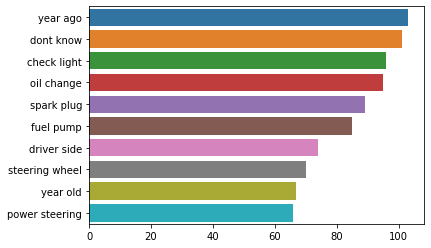

In [ ]:
corpus = []
new = data['Leading Comment'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

from collections import defaultdict

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

import seaborn as sns

top_n_bigrams=get_top_ngram(data['Leading Comment'],2)[:10]
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

<AxesSubplot:>

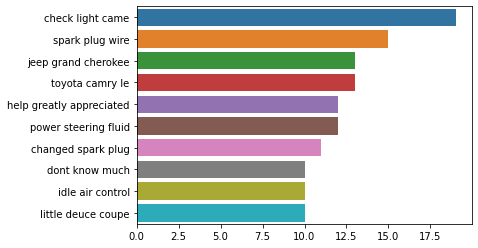

In [ ]:
top_tri_grams=get_top_ngram(data['Leading Comment'],n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

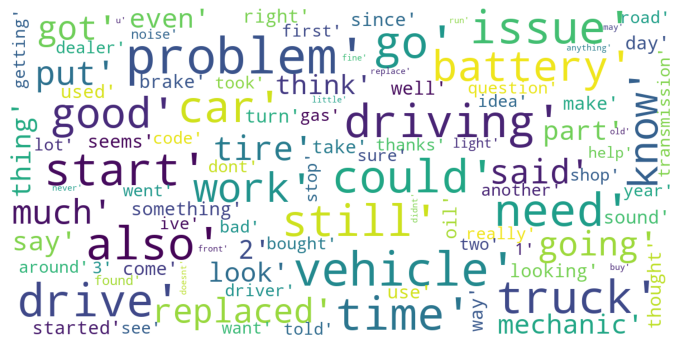

In [ ]:
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)